# Airbnb Price Prediction

## Loading & Preparing

In [41]:
# Core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Text processing and visualization
from wordcloud import WordCloud

# Scikit-learn: Pipelines and transformers
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin

# Scikit-learn: Preprocessing
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer

# Scikit-learn: Model selection and splitting
from sklearn.model_selection import train_test_split, GroupKFold, GroupShuffleSplit, GridSearchCV
from sklearn.utils import shuffle
from sklearn.cluster import KMeans

# Scikit-learn: Metrics
from sklearn.metrics import r2_score, mean_squared_error, make_scorer  # Added make_scorer for custom metrics

# Scikit-learn: Models
from sklearn.linear_model import Ridge, Lasso, LinearRegression, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

# XGBoost
from xgboost import XGBRegressor

# Geospatial analysis
import folium


In [42]:
data = pd.read_csv("listings.csv")
data.shape[0]

44684

## EDA

#### General Dataset

In [43]:
total_missing_rows = data[data.isnull().any(axis=1)].shape[0]

print(total_missing_rows)

44684


In [44]:
num_rows = data.shape[0]
num_columns = data.shape[1]
column_names = data.columns.tolist()
missing_values = data.isnull().sum()
missing_percentage = (missing_values / num_rows) * 100

# Data dimensions
print('Data dimensions:', data.shape)

# Fraction of missing values per feature
perc_missing_per_ftr = data.isnull().sum(axis=0) / data.shape[0]
print('Fraction of missing values in features:')
print(perc_missing_per_ftr[perc_missing_per_ftr > 0])

# Data types of the features with missing values
print('Data types of the features with missing values:')
print(data[perc_missing_per_ftr[perc_missing_per_ftr > 0].index].dtypes)

# Fraction of points (rows) with missing values
frac_missing = sum(data.isnull().sum(axis=1) != 0) / data.shape[0]
print('Fraction of points with missing values:', frac_missing)

Data dimensions: (44684, 75)
Fraction of missing values in features:
name                           0.000022
description                    0.029876
neighborhood_overview          0.466498
host_name                      0.000045
host_since                     0.000045
host_location                  0.236170
host_about                     0.454950
host_response_time             0.218490
host_response_rate             0.218490
host_acceptance_rate           0.208218
host_is_superhost              0.006490
host_thumbnail_url             0.000045
host_picture_url               0.000045
host_neighbourhood             0.216050
host_listings_count            0.000045
host_total_listings_count      0.000045
host_verifications             0.000045
host_has_profile_pic           0.000045
host_identity_verified         0.000045
neighbourhood                  0.466476
bathrooms                      0.182280
bathrooms_text                 0.000604
bedrooms                       0.062058
beds       

In [45]:
x_train_shape = X_train.shape

missing_rows_count = X_train.isnull().any(axis=1).sum()

print(f"Shape of X_train: {x_train_shape}")
print(f"Number of rows with missing values in X_train: {missing_rows_count}")


NameError: name 'X_train' is not defined

#### Target

In [ ]:
print(data[target].describe())

count    36540.000000
mean       317.199781
std       1103.192069
min          6.000000
25%         99.000000
50%        160.000000
75%        276.000000
max      99999.000000
Name: price, dtype: float64


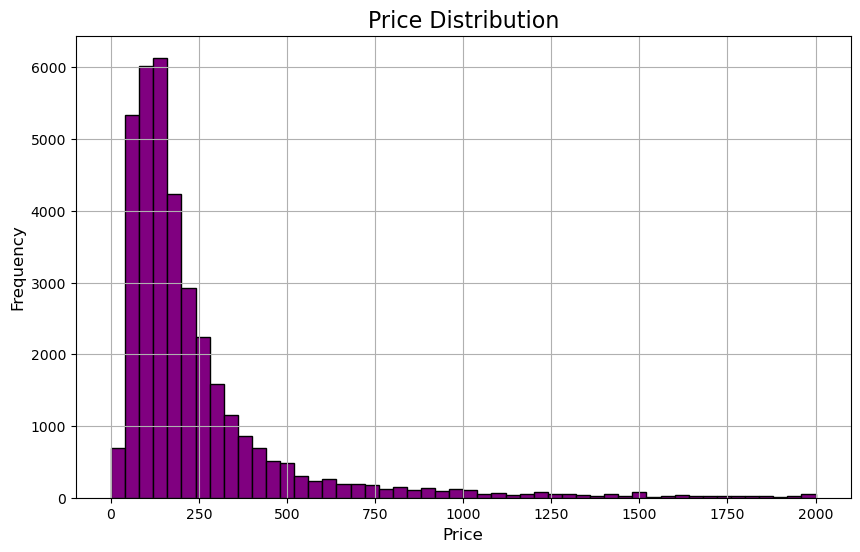

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(data['price'], bins=50, color='purple', edgecolor='black', range=(0, 2000))
plt.title('Price Distribution', fontsize=16)
plt.xlabel('Price', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(True)
plt.show()

#### Target Vs Features

##### Price Vs Property Characteristics

C:\Users\mdall\AppData\Local\Temp\ipykernel_4932\1828662774.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=top_filtered_data, x='property_type', y='price', palette='viridis', order=mean_prices.index)


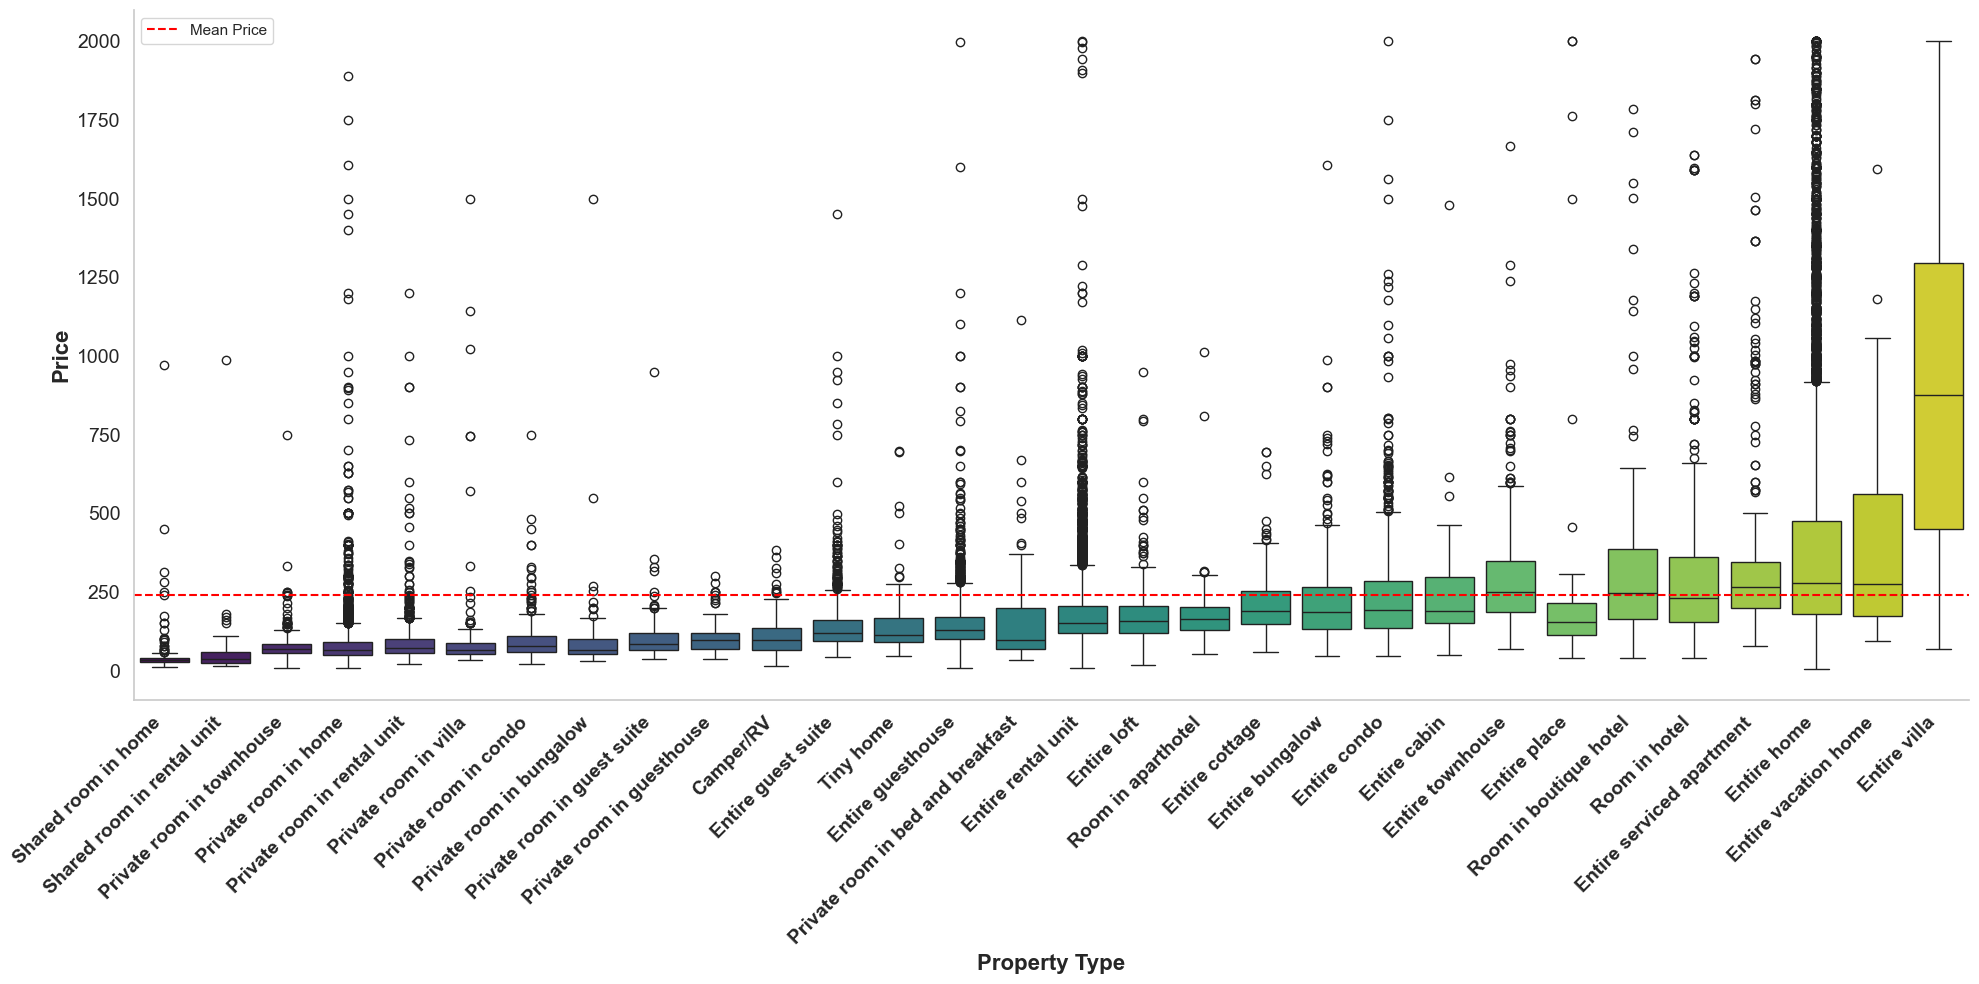

Top 30 Most Common Property Types:
property_type
Entire home                          10513
Entire rental unit                    9325
Private room in home                  4523
Entire guesthouse                     2384
Entire condo                          1458
Private room in rental unit           1209
Entire guest suite                    1110
Entire townhouse                       615
Entire villa                           481
Entire bungalow                        426
Entire serviced apartment              420
Room in hotel                          393
Private room in townhouse              343
Private room in condo                  339
Entire loft                            260
Private room in villa                  220
Shared room in home                    186
Private room in guest suite            169
Room in boutique hotel                 165
Tiny home                              144
Entire cottage                         139
Private room in bed and breakfast      139
Campe

In [ ]:

sns.set(style='whitegrid', palette='muted')

# Filter the data for prices between 0 and 2000
filtered_data = data[(data['price'] >= 0) & (data['price'] <= 2000)]

# Get the top 30 most common property types
top_property_types = filtered_data['property_type'].value_counts().nlargest(30).index

# Filter the data to include only the top 30 property types
top_filtered_data = filtered_data[filtered_data['property_type'].isin(top_property_types)]

# Calculate the mean price for each property type in the top 30
mean_prices = top_filtered_data.groupby('property_type')['price'].mean().sort_values()

# Set the size of the figure (increase width for better fitting of labels)
plt.figure(figsize=(20, 10))  # Wider figure for better label visibility

# Create the box plot sorted by mean price
sns.boxplot(data=top_filtered_data, x='property_type', y='price', palette='viridis', order=mean_prices.index)

# Set the title and labels with font size and weight
plt.xlabel('Property Type', fontsize=16, fontweight='bold')
plt.ylabel('Price', fontsize=16, fontweight='bold')

# Remove the outline and grid lines
sns.despine()  # Remove the top and right spines
plt.grid(False)  # Disable the grid

# Adjust x-axis tick labels for better visibility with increased font size
plt.xticks(rotation=45, ha='right', fontsize=14, fontweight='bold')  # Increased font size and bold font
plt.yticks(fontsize=14)

# Add a horizontal line at the mean price
mean_price = top_filtered_data['price'].mean()  # Mean price for the filtered data
plt.axhline(mean_price, color='red', linestyle='--', label='Mean Price')
plt.legend()

# Show the plot
plt.tight_layout()  # Adjust the layout for better spacing
plt.show()

# Find the most common property types
most_common_property_types = top_filtered_data['property_type'].value_counts().head(30)
print("Top 30 Most Common Property Types:")
print(most_common_property_types)

##### Price Vs Neighbourhood

In [ ]:
# Sample DataFrame for demonstration (replace this with your actual data)
# data = pd.read_csv('your_data_file.csv')

# Create a base map centered around LA with a less prominent background
la_location = [34.0522, -118.2437]  # Coordinates for Los Angeles
m = folium.Map(location=la_location, zoom_start=12, tiles='CartoDB positron')  # Using CartoDB positron for a lighter background

# Prepare the data: Filter out rows where price is NaN
filtered_data = data.dropna(subset=['price'])

# Sample a subset of data for faster processing (e.g., 10% of the data)
sample_size = int(len(filtered_data) * 0.1)
filtered_data_sample = filtered_data.sample(n=sample_size, random_state=42)

# Define a function to get color based on price ranges
def get_color(price):
    if price < 50:
        return 'green'
    elif 50 <= price < 100:
        return 'lime'
    elif 100 <= price < 150:
        return 'yellow'
    elif 150 <= price < 200:
        return 'orange'
    elif 200 <= price < 250:
        return 'red'
    elif 250 <= price < 300:
        return 'darkred'
    else:
        return 'black'  # For prices 300 and above

# Add CircleMarkers for each listing
for index, row in filtered_data_sample.iterrows():
    # Set a fixed radius
    radius = 7  # You can adjust this value as needed
    folium.CircleMarker(
        location=(row['latitude'], row['longitude']),
        radius=radius,
        color=get_color(row['price']),  # Change color based on price ranges
        fill=True,
        fill_color=get_color(row['price']),
        fill_opacity=0.6,
        popup=f'Price: ${row["price"]}'  # Display price on click
    ).add_to(m)

# Define a function to create a legend
def add_legend(map_object):
    legend_html = '''
    <div style="position: fixed; 
                bottom: 50px; left: 50px; 
                width: 200px; height: auto; 
                z-index: 1000; 
                font-size: 14px; 
                background-color: white; 
                padding: 10px; 
                border: 2px solid grey; 
                border-radius: 5px;">
        <h4 style="text-align: center;">Price Range Legend</h4>
        <i style="background: green; border-radius: 50%; width: 20px; height: 20px; display: inline-block;"></i> <span>< $50<br></span>
        <i style="background: lime; border-radius: 50%; width: 20px; height: 20px; display: inline-block;"></i> <span>$50 - $100<br></span>
        <i style="background: yellow; border-radius: 50%; width: 20px; height: 20px; display: inline-block;"></i> <span>$100 - $150<br></span>
        <i style="background: orange; border-radius: 50%; width: 20px; height: 20px; display: inline-block;"></i> <span>$150 - $200<br></span>
        <i style="background: red; border-radius: 50%; width: 20px; height: 20px; display: inline-block;"></i> <span>$200 - $250<br></span>
        <i style="background: darkred; border-radius: 50%; width: 20px; height: 20px; display: inline-block;"></i> <span>$250 - $300<br></span>
        <i style="background: black; border-radius: 50%; width: 20px; height: 20px; display: inline-block;"></i> <span> > $300<br></span>
    </div>
    '''
    map_object.get_root().html.add_child(folium.Element(legend_html))

add_legend(m)

m

##### Price Vs Review Sentiment

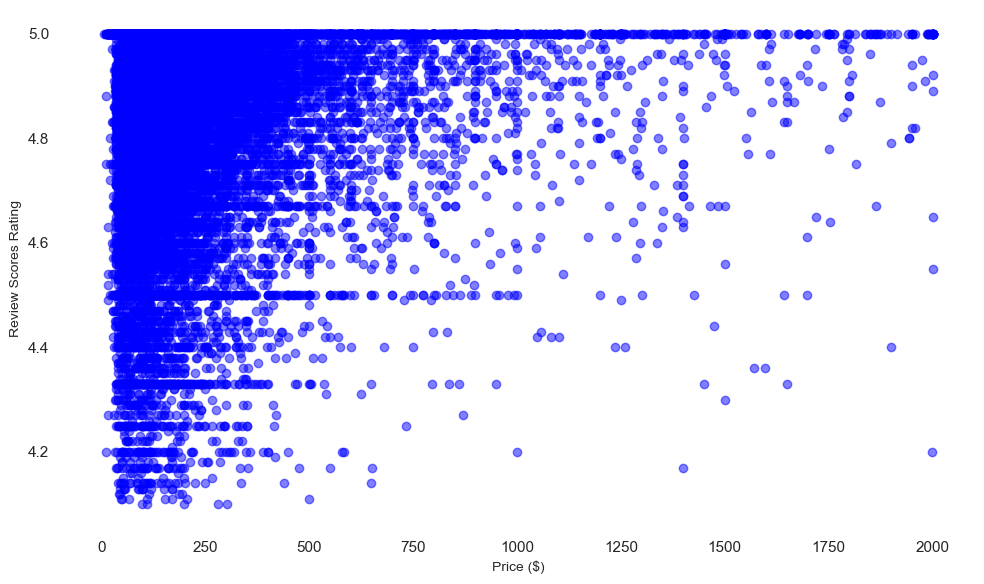

In [ ]:
# Filter data for prices between 0 and 2000 and ratings between 4.85 and 5
filtered_data = data[(data['price'] >= 0) & (data['price'] <= 2000) & (data['review_scores_rating'] >= 4.1)]

# Create the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(filtered_data['price'], filtered_data['review_scores_rating'], alpha=0.5, color='blue')

# Set the labels with reduced font size
plt.xlabel('Price ($)', fontsize=10)
plt.ylabel('Review Scores Rating', fontsize=10)

# Remove grid lines, borders, and title for a cleaner look
plt.box(False)  # Remove the border
plt.grid(False)  # Remove grid lines

# Show the plot
plt.tight_layout()
plt.show()

#### Qualitative

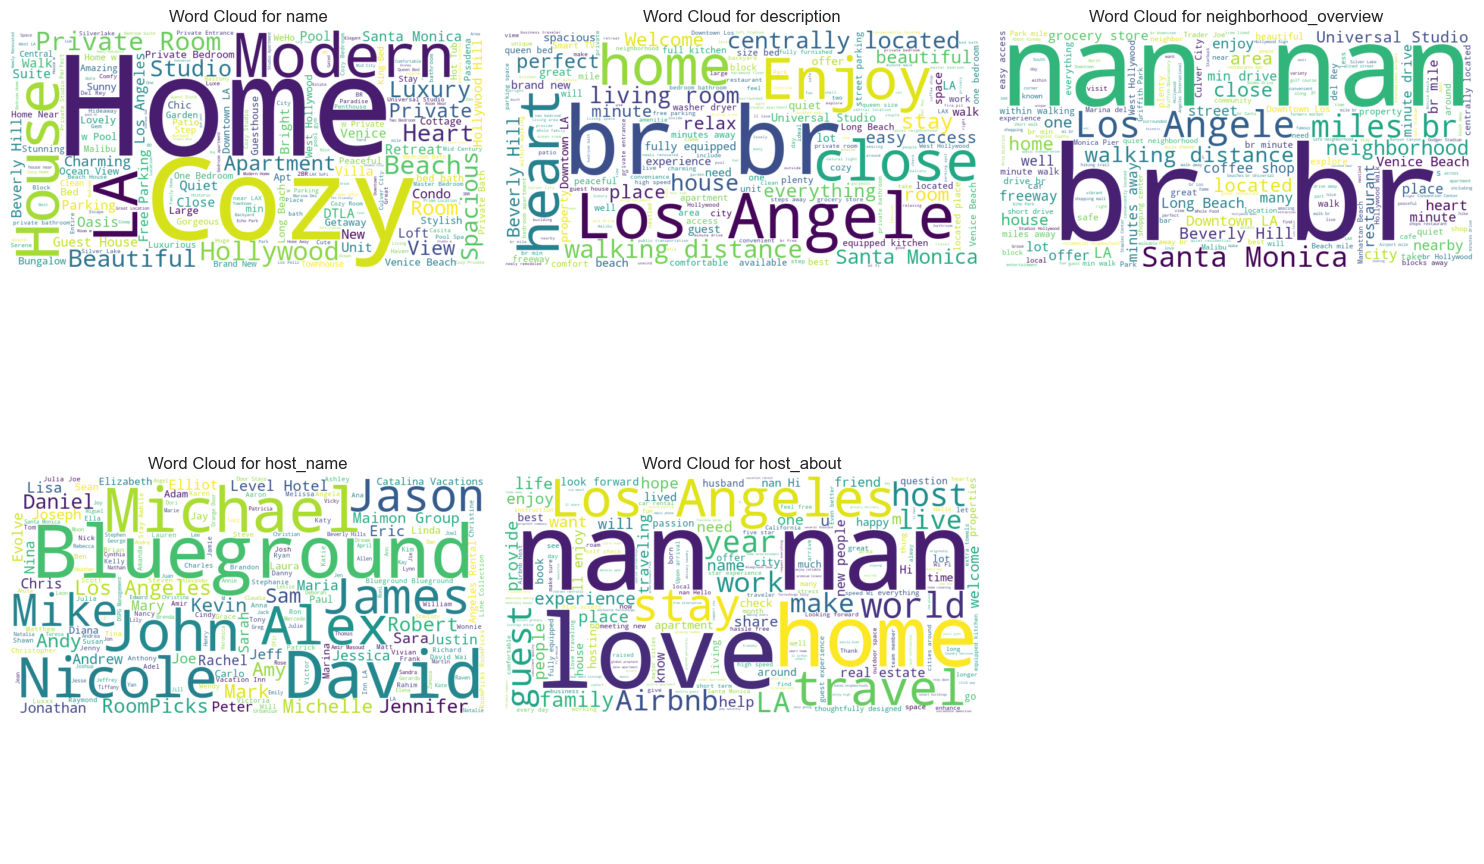

In [ ]:
# Create subplots for word clouds
num_features = len(qualitative_features)
num_columns = 3  # Number of plots per row
num_rows = (num_features + num_columns - 1) // num_columns  # Calculate rows needed

fig, axes = plt.subplots(nrows=num_rows, ncols=num_columns, figsize=(15, 5 * num_rows))

# Flatten the axes array for easy indexing
axes = axes.flatten()

# Generate word clouds for each qualitative feature
for i, feature in enumerate(qualitative_features):
    # Generate the word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(data[feature].dropna()))
    
    # Display the word cloud
    axes[i].imshow(wordcloud, interpolation='bilinear')
    axes[i].axis("off")
    axes[i].set_title(f'Word Cloud for {feature}')

# Hide any unused axes
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

# Adjust layout
plt.tight_layout()
plt.show()

#### Categorical

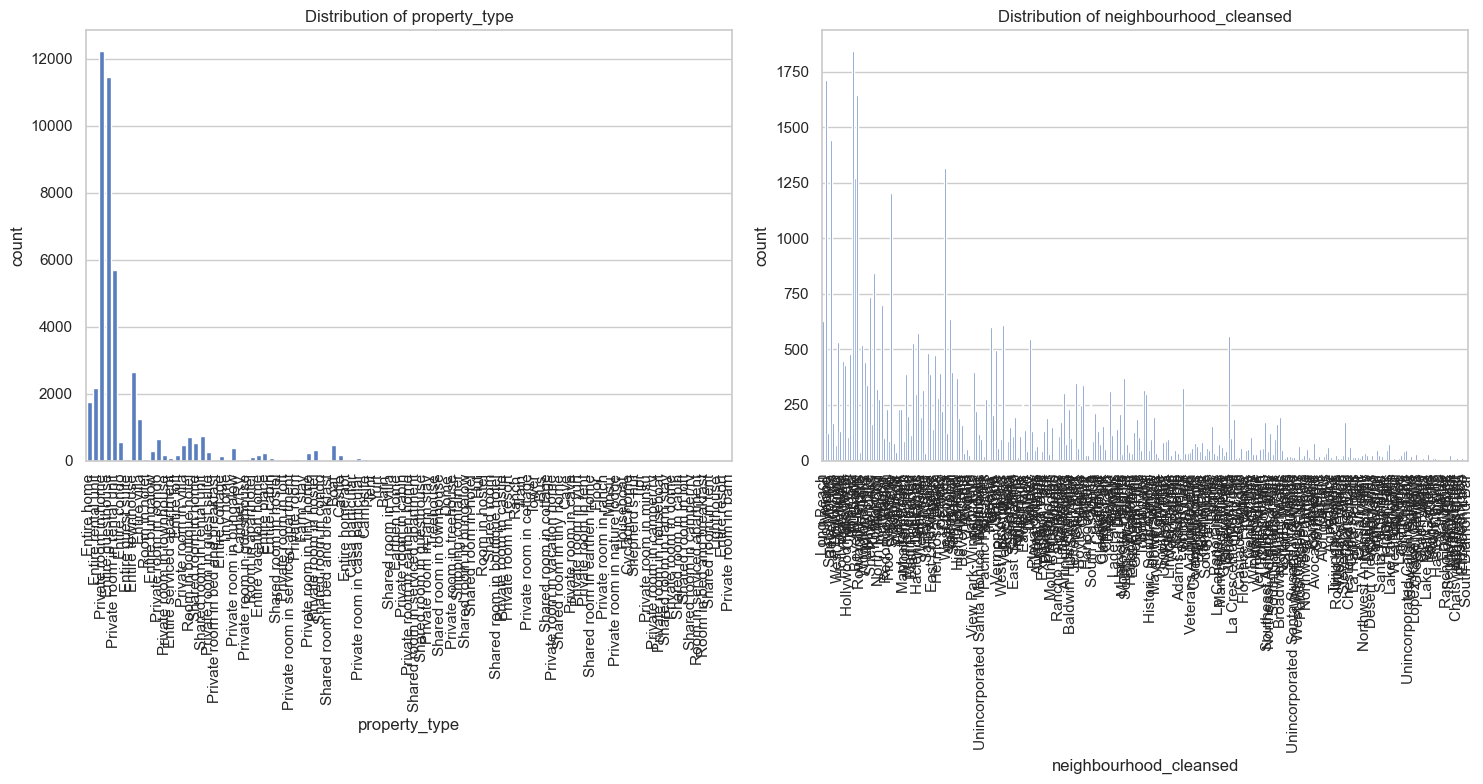

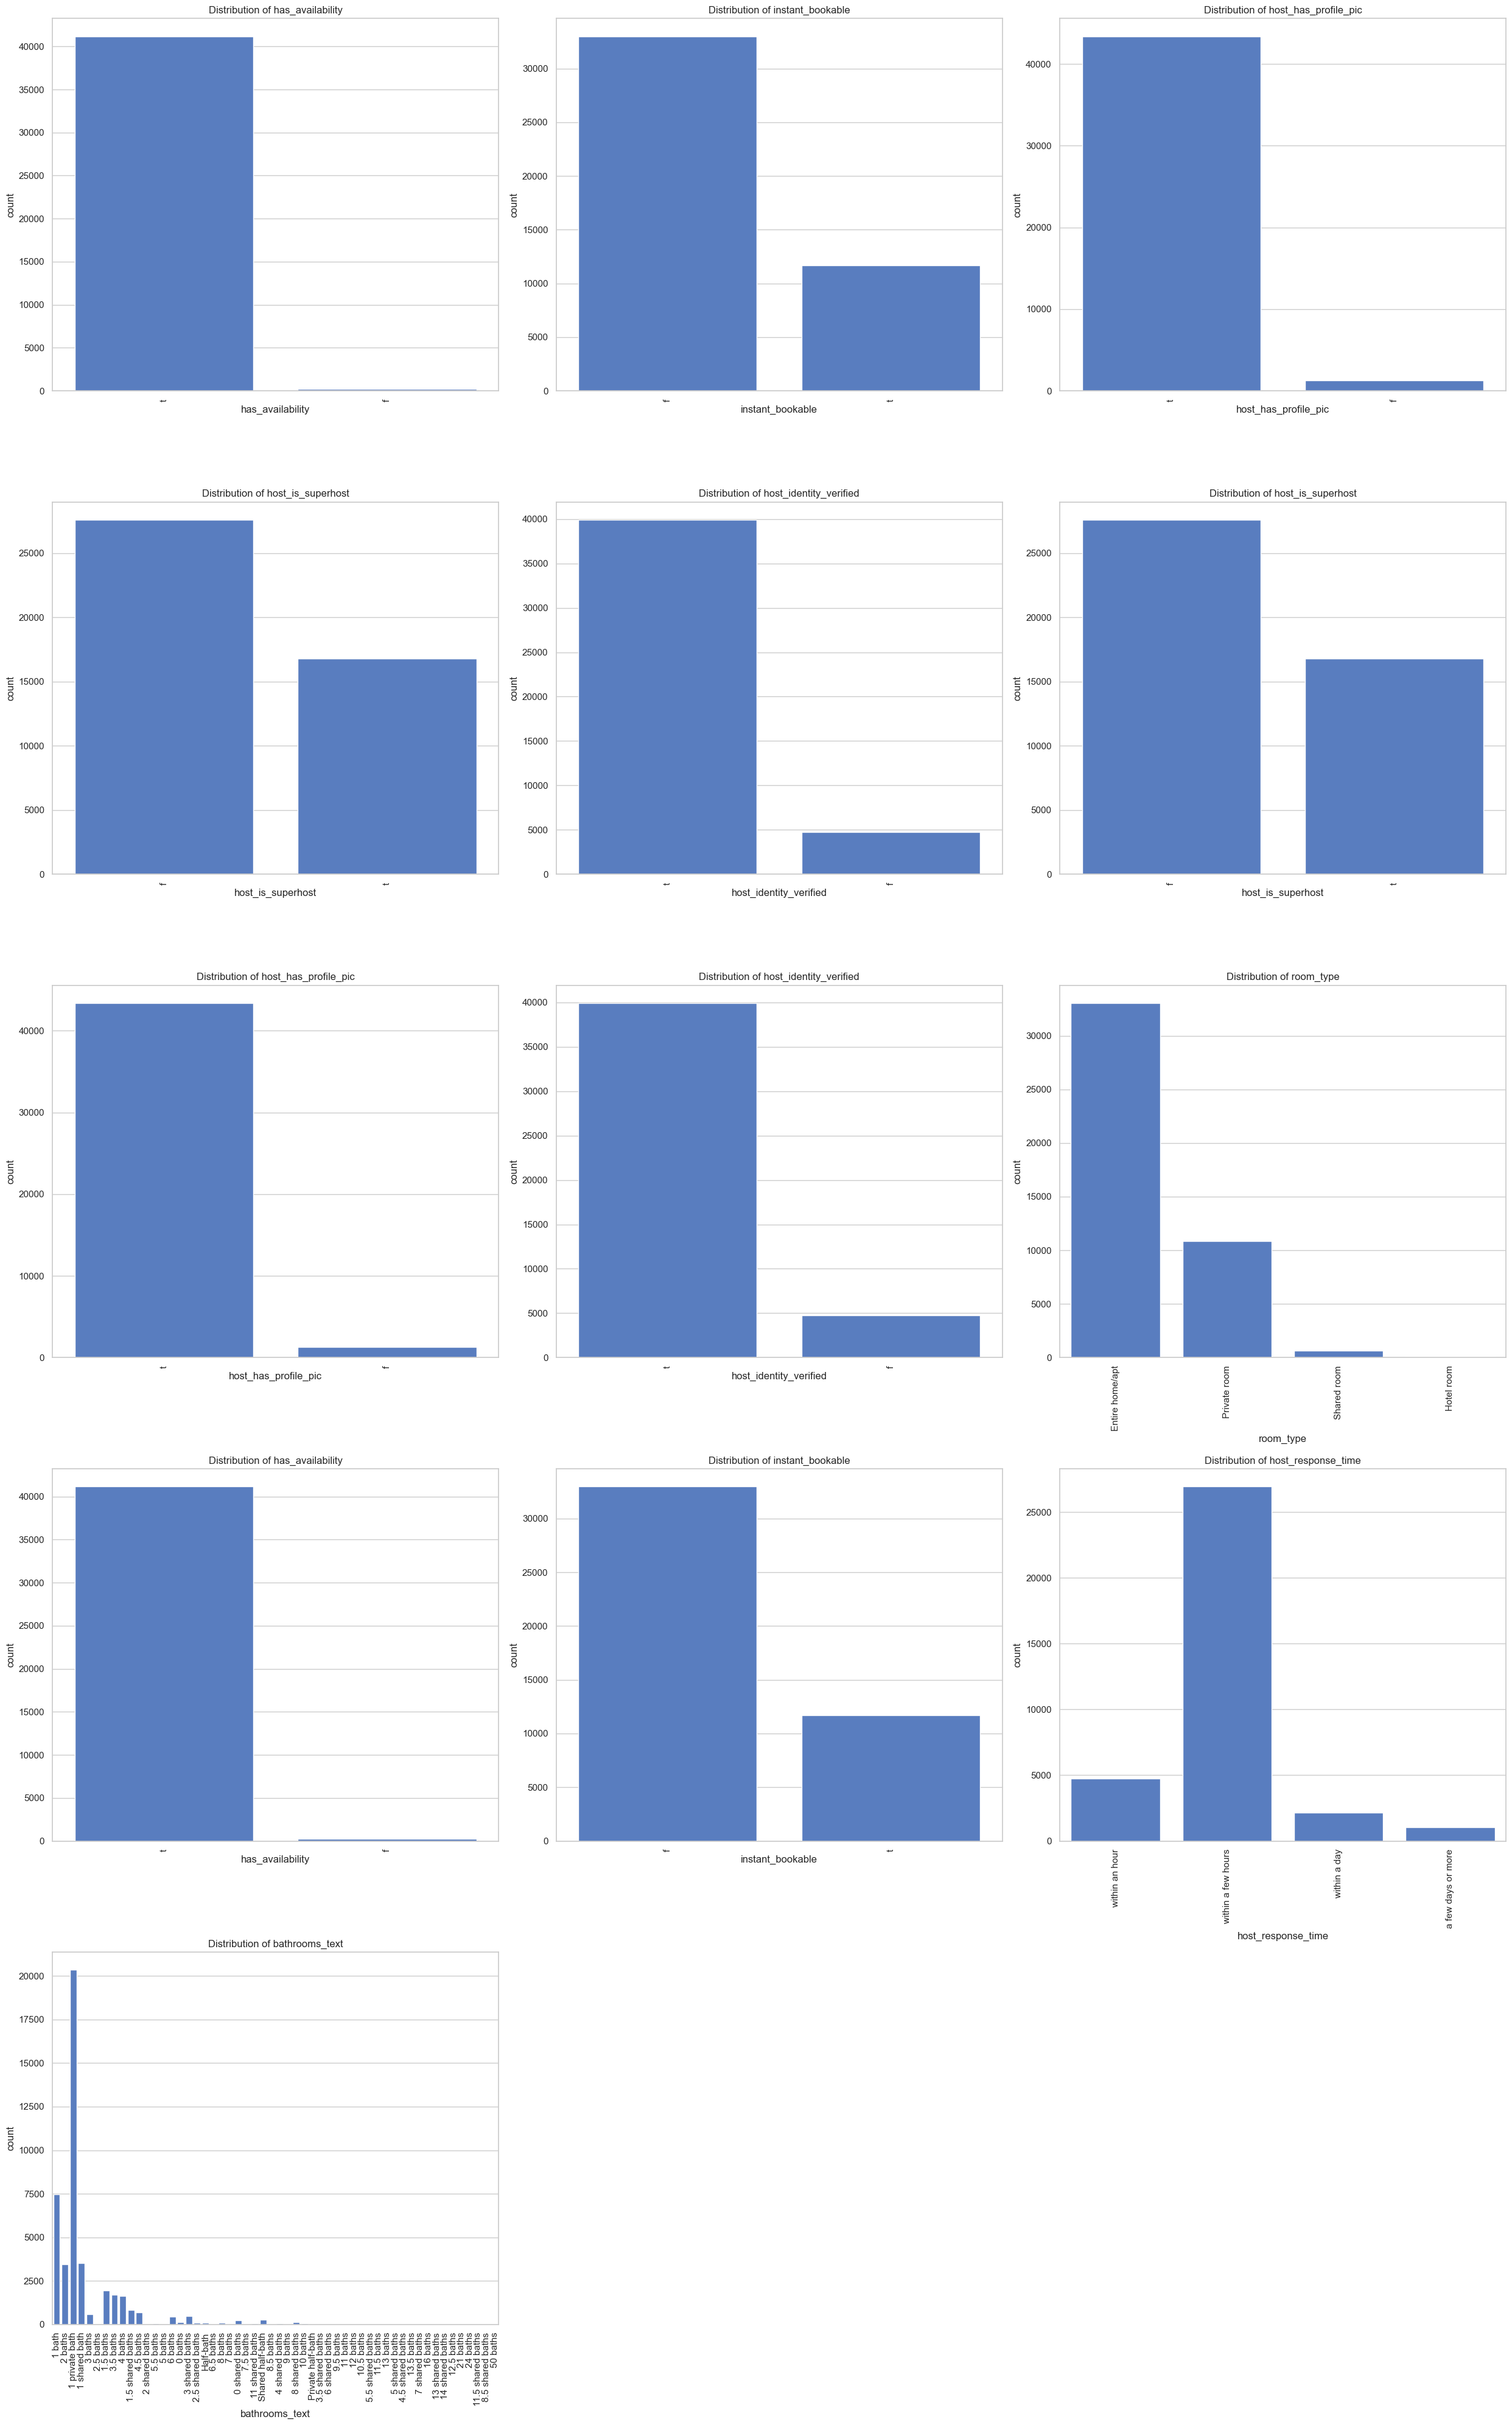

In [ ]:
specific_features = ['property_type', 'neighbourhood_cleansed']
other_categorical_features = [feature for feature in binary_categorical_features + multi_categorical_features if feature not in specific_features]

fig, axes = plt.subplots(nrows=1, ncols=len(specific_features), figsize=(15, 8))

for i, feature in enumerate(specific_features):
    sns.countplot(x=data[feature], ax=axes[i])
    axes[i].set_title(f'Distribution of {feature}')
    axes[i].set_xticks(range(len(data[feature].value_counts())))  
    axes[i].set_xticklabels(data[feature].value_counts().index, rotation=90) 

plt.tight_layout()
plt.show()

num_features = len(other_categorical_features)
num_columns = 3 
num_rows = (num_features + num_columns - 1) // num_columns  

fig, axes = plt.subplots(nrows=num_rows, ncols=num_columns, figsize=(25, 8 * num_rows))

axes = axes.flatten()

for i, feature in enumerate(other_categorical_features):
    sns.countplot(x=data[feature], ax=axes[i])
    axes[i].set_title(f'Distribution of {feature}')
    axes[i].set_xticks(range(len(data[feature].value_counts())))  
    axes[i].set_xticklabels(data[feature].value_counts().index, rotation=90)

for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

#### Continous

In [ ]:
all_features = continuous_features + continous_features_minmax
num_features = len(all_features)
num_columns = 3 
num_rows = (num_features + num_columns - 1) // num_columns

fig, axes = plt.subplots(nrows=num_rows, ncols=num_columns, figsize=(25, 4 * num_rows))

axes = axes.flatten()

for i, feature in enumerate(all_features):
    if feature in continuous_features:
        sns.histplot(data[feature], kde=True, ax=axes[i])
        axes[i].set_title(f'Distribution of {feature}')
        axes[i].set_xlabel(feature)
    else:
        sns.countplot(x=data[feature], ax=axes[i])
        axes[i].set_title(f'Distribution of {feature}')
        axes[i].set_xlabel(feature)
        
        axes[i].set_xticks(axes[i].get_xticks())  
        axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45)

for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

KeyboardInterrupt: 

## Preprocessing

#### Seperating Columns

In [50]:
# Non-essential features that won't be directly used for modeling
non_essential_features = [
    "id", "listing_url", "scrape_id", "last_scraped", "source", "picture_url", "host_id", 
    "host_url", "host_thumbnail_url", "host_picture_url", "license", "calendar_updated", 
    "calendar_last_scraped", "host_listings_count", "host_since", "host_location", 
    "neighbourhood", "first_review", "last_review", "host_neighbourhood", 
    "host_verifications", "neighbourhood_group_cleansed", "review_scores_location", 
    "host_acceptance_rate", "host_response_rate"
]

# Continuous features to be standardized
continuous_features_std = [
    "review_scores_accuracy", "review_scores_cleanliness", 
    "review_scores_checkin", "review_scores_communication", "review_scores_value", 
    "review_scores_rating", "number_of_reviews", "number_of_reviews_ltm", "reviews_per_month", 
    "number_of_reviews_l30d", "calculated_host_listings_count", 
    "calculated_host_listings_count_entire_homes", "calculated_host_listings_count_private_rooms", 
    "calculated_host_listings_count_shared_rooms", "host_total_listings_count", 
    "minimum_minimum_nights", "maximum_maximum_nights", "minimum_nights", 
    "maximum_nights", "minimum_nights_avg_ntm", "minimum_maximum_nights", 
    "maximum_nights_avg_ntm", "maximum_minimum_nights"
]

# Continuous features to be scaled using MinMaxScaler
continuous_features_minmax = [
    "accommodates", "bathrooms", "beds", "availability_30", "availability_60", 
    "availability_90", "availability_365", "bedrooms"
]

# Categorical features (binary and multi-categorical combined)
categorical_features = [
    "has_availability", "instant_bookable", "host_has_profile_pic", "host_is_superhost", 
    "host_identity_verified", "property_type", "room_type", "neighbourhood_cleansed", 
    "host_response_time", "bathrooms_text"
]

# Qualitative features
qualitative_features = [
    "name", "description", "neighborhood_overview", "host_name", "host_about"
]

# Target variable
target = "price"


#### Converting Columns to Appriopriate Data Type

In [51]:
for column in continuous_features_std:
    data[column] = data[column].astype(str).str.replace('%', '', regex=False).astype(float)

data['price'] = data['price'].str.replace('$', '', regex=False).str.replace(',', '', regex=False).astype(float)

data[qualitative_features] = data[qualitative_features].astype(str)

#### Dropping non relevant features and missing target variables

In [52]:
data = data.drop(columns = non_essential_features + qualitative_features)
data = data.dropna(subset=[target])

#### Transforming price to log price

In [53]:
data['price'] = np.log(data['price'])

#### Setting up variables

In [ ]:
X = data.drop(columns=[target]).iloc[]
y = data[target].iloc[:5000]
groups = data['neighbourhood_cleansed']

## ML Deployment & Hyperparameter Tuning

In [55]:
# XGBoost-based Iterative Imputer
xgb_imputer = IterativeImputer(
    estimator=XGBRegressor(n_estimators=100, max_depth=5, learning_rate=0.1, random_state=42),
    max_iter=10,
    random_state=42
)

# Preprocessor with XGBoost Imputation
preprocessor = ColumnTransformer(
    transformers=[
        # Continuous features with XGBoost imputer and StandardScaler
        ('continuous', Pipeline(steps=[
            ('imputer', xgb_imputer),
            ('scaler', StandardScaler())
        ]), continuous_features_std),

        # Continuous features with MinMaxScaler (use a simpler imputer if needed)
        ('nominal', Pipeline(steps=[
            ('imputer', xgb_imputer),  # Changed from xgb_imputer
            ('scaler', MinMaxScaler())
        ]), continuous_features_minmax),

        # Categorical features with SimpleImputer and OneHotEncoder
        ('categorical', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
            ('encoder', OneHotEncoder(handle_unknown='ignore', drop='first'))
        ]), categorical_features)
    ],
    remainder='drop',  # Drop other features not listed
    verbose=True
)

In [ ]:
# Spatial clustering for group creation
kmeans = KMeans(n_clusters=10, random_state=42).fit(X[['latitude', 'longitude']])
groups = kmeans.labels_

print("KMeans Spatial Groups:", np.unique(groups, return_counts=True))
assert len(groups) == len(X), "Mismatch between spatial_groups and X."

KMeans Spatial Groups: (array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([2832, 9549, 1950, 5964,  644, 7979, 3699, 1971, 1735,  217],
      dtype=int64))


In [75]:
def MLpipe(X, y, preprocessor, model, param_grid, groups, nr_states):
    '''
    This function splits the data into train/test (80/20) and applies KFold with 5 folds to the train set.
    The RMSE is minimized during cross-validation.

    Parameters:
        X (pd.DataFrame or np.ndarray): Feature matrix.
        y (pd.Series or np.ndarray): Target variable.
        preprocessor (ColumnTransformer): Preprocessing pipeline.
        model (Estimator): Initialized machine learning model.
        param_grid (dict): Parameter grid for GridSearchCV.
        groups (list or np.ndarray): Group labels for samples.
        nr_states (int): Number of random states for repeated splits.
    
    Returns:
        list: List of test scores.
        list: List of trained models from GridSearchCV.
        pd.DataFrame: DataFrame containing train and validation scores for each fold.
    '''
    test_scores = []
    final_models = []
    all_cv_results = []

    for state in range(nr_states):
        print(f"\nRandom State {state + 1}\n")

        X = X.iloc[:5000] # for speed of processing 
        y = y.iloc[:5000] # for speed of processing
        groups = groups.iloc[:5000] # for speed of processing

        # Group-aware train/test split
        gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42 + state)
        train_idx, test_idx = next(gss.split(X, y, groups))

        # Split data into train/validation and test sets
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        groups_train = groups.iloc[train_idx]

        # GroupKFold for 5-fold cross-validation
        gkf = GroupKFold(n_splits = 5)

        # Create a named pipeline with preprocessing and model
        pipe = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('model', model)
        ])

        # Perform GridSearchCV with GroupKFold
        grid_search = GridSearchCV(
            estimator=pipe,
            param_grid=param_grid,
            cv=gkf.split(X_train, y_train, groups_train),
            scoring='neg_root_mean_squared_error',
            return_train_score=True,
            n_jobs=-1,
            verbose=0
        )

        # Fit the GridSearchCV
        grid_search.fit(X_train, y_train)
        print(f"Best parameters: {grid_search.best_params_}")
        print(f"Best CV RMSE: {-grid_search.best_score_:.4f}")

        # Evaluate on the test set
        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test)
        test_rmse = np.sqrt(np.mean((y_pred - y_test) ** 2))
        print(f"Test RMSE: {test_rmse:.4f}")

        # Store results
        test_scores.append(test_rmse)
        final_models.append(best_model)

        # Consolidate CV results into a DataFrame
        results_df = pd.DataFrame(grid_search.cv_results_)
        results_df['random_state'] = state
        all_cv_results.append(results_df)

    # Combine all CV results into a single DataFrame
    combined_cv_results = pd.concat(all_cv_results, ignore_index=True)
    return test_scores, final_models, combined_cv_results

In [ ]:
# Dictionary to store final results
results = {}

# Models and hyperparameters
models = {
    'ridge_regression': (
        Ridge(), 
        {
            'model__alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000]  # Regularization strength
        }
    ), 
    'elastic_net': (
        ElasticNet(), 
        {
            'model__alpha': [0.001, 0.01, 0.1, 1, 10, 100], 
            'model__l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]  # L1 vs. L2 regularization balance
        }
    ),
    'svm': (
        SVR(), 
        {
            'model__C': [0.01, 0.1, 1, 10, 100, 1000], 
            'model__gamma': [0.001, 0.01, 0.1, 1, 10]  # Kernel influence
        }
    ),
    'random_forest': (
        RandomForestRegressor(), 
        {
            'model__n_estimators': [50, 100, 200, 300, 500], 
            'model__max_depth': [None, 5, 10, 20, 50]  # Tree depth
        }
    )
}

# Training loop for models
for model_name, (model, param_grid) in models.items():
    print(f"\nTraining {model_name}")
    
    # Train the model using MLpipe
    test_scores, final_models, _ = MLpipe(
        X=X,
        y=y,
        preprocessor=preprocessor,
        model=model,
        param_grid=param_grid,
        groups=groups,
        nr_states=10 # Set the number of random states
    )
    
    # Calculate mean and std RMSE
    mean_rmse = np.mean(test_scores)
    std_rmse = np.std(test_scores)

    # Store results
    results[model_name] = {
        'mean_rmse': mean_rmse,
        'std_rmse': std_rmse,
        'test_scores': test_scores,
        'models': final_models
    }

    print(f"{model_name} Results:")
    print(f"Mean RMSE: {mean_rmse:.4f}")
    print(f"Std RMSE: {std_rmse:.4f}")

# Identify the best model based on mean RMSE
best_model_name = min(results, key=lambda x: results[x]['mean_rmse'])
best_model = results[best_model_name]['models']

print("\nBest Model:", best_model_name)
print(f"Mean RMSE: {results[best_model_name]['mean_rmse']:.4f}")
print(f"Std RMSE: {results[best_model_name]['std_rmse']:.4f}")


Training ridge_regression

Random State 1

[ColumnTransformer] .... (1 of 3) Processing continuous, total=   4.7s
[ColumnTransformer] ....... (2 of 3) Processing nominal, total=   1.3s
[ColumnTransformer] ... (3 of 3) Processing categorical, total=   0.0s
Best parameters: {'model__alpha': 10}
Best CV RMSE: 0.5111
Test RMSE: 0.4720

Random State 2



c:\Users\mdall\anaconda3\envs\DATA1030\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [5, 7, 9] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[ColumnTransformer] .... (1 of 3) Processing continuous, total=   9.0s
[ColumnTransformer] ....... (2 of 3) Processing nominal, total=   2.5s
[ColumnTransformer] ... (3 of 3) Processing categorical, total=   0.0s
Best parameters: {'model__alpha': 10}
Best CV RMSE: 0.4996
Test RMSE: 0.5102

Random State 3



c:\Users\mdall\anaconda3\envs\DATA1030\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [5, 7, 9] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[ColumnTransformer] .... (1 of 3) Processing continuous, total=   4.9s
[ColumnTransformer] ....... (2 of 3) Processing nominal, total=   0.7s
[ColumnTransformer] ... (3 of 3) Processing categorical, total=   0.0s
Best parameters: {'model__alpha': 10}
Best CV RMSE: 0.5170
Test RMSE: 0.4146

Random State 4



c:\Users\mdall\anaconda3\envs\DATA1030\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0, 5, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
